In [47]:
import numpy as np
import math
import pandas as pd
from pandas import DataFrame, Series
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model
import scipy, scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
%matplotlib inline
import pymc3 as pm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Introduction
Problem Statement: What is the the spending score of a customer at mall  

Data Description:
<br>CustomerId: Customer's unique ID
<br>Gender: Customer's gender
<br>Age: Customer's age
<br>Annual Income: customer's annual income
<br>Spending Score: A score, out of 100, to rate customer's behavior and money spent 



In [9]:
df = pd.read_csv('./Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Preliminary inspection of the data 

In [10]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [12]:
df = df.drop(['CustomerID'], axis=1)
df=df.rename(index=str, columns={"Annual Income (k$)": "Annual_Income", "Spending Score (1-100)": "Spending_Score"})

The column CustomerID is removed because it is a unique id for every customer. Therefore, it would not impact the spending score of the customer

In [13]:
df.head()

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


### Data Exploration

In [14]:
df.describe()

,Age,Annual_Income,Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [15]:
df.isnull().sum()

Gender            0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64

It is determined that there are no empty data in any of the columns

### Data Visualization

/Users/jyoti/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


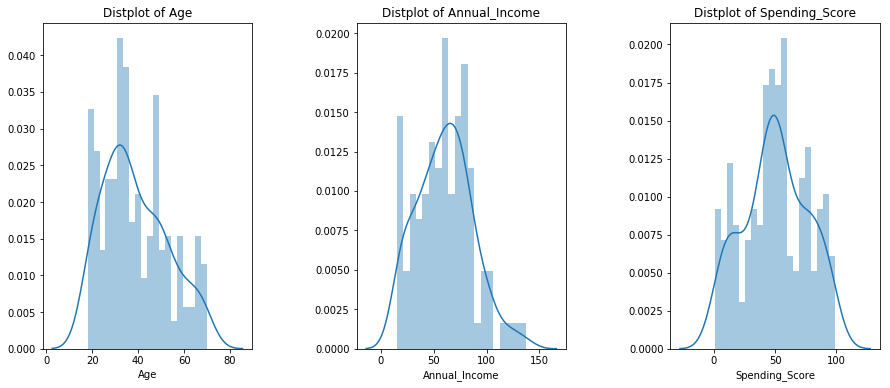

In [16]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual_Income' , 'Spending_Score']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

From the histogram plots we see that the dependent variables and independent variables are normally distributed. Therefore, we can use OLS regression analysis on this data.

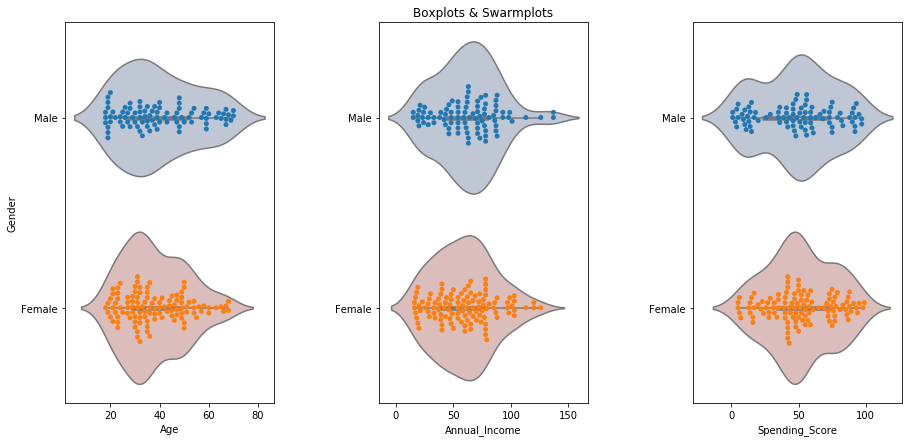

In [17]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for cols in ['Age' , 'Annual_Income' , 'Spending_Score']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

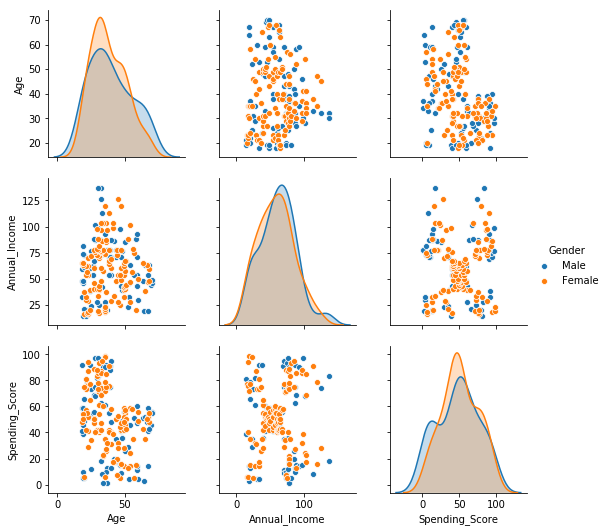

In [18]:
sns.pairplot(df,hue='Gender')

We see that Age, Annual Income are not collinear. The corelation between the spending score, age and annual income are low.

In [19]:
result = smf.ols(formula='Spending_Score ~ Annual_Income + Age + Gender-1', data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Spending_Score   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     7.960
Date:                Thu, 01 Aug 2019   Prob (F-statistic):           4.91e-05
Time:                        05:54:20   Log-Likelihood:                -922.05
No. Observations:                 200   AIC:                             1852.
Df Residuals:                     196   BIC:                             1865.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Gender[Female]    73.9300      6.642     11.130      0.000      60.831      87.029
Gender[Male]      71.9168      7.023     10.240      0.000      58.067      85.767
Annual_Income      0.0079      0.066      0.119      0.905      -0.123       0.139
Age               -0.6004      0.125     -4.806      0.000      -0.847      -0.354
==============================================================================
Omnibus:                       11.059   Durbin-Watson:                   3.448
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                6.033
Skew:                          -0.233   Prob(JB):                       0.0490
Kurtosis:                       2.288   Cond. No.                         407.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
df['GenderGroup'] = df['Gender'].apply(lambda x: 1 if x =='Male' else 0)

In [21]:
result = smf.ols(formula='Spending_Score ~ Annual_Income + Age + GenderGroup-1', data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Spending_Score   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     150.9
Date:                Thu, 01 Aug 2019   Prob (F-statistic):           8.42e-51
Time:                        05:54:20   Log-Likelihood:                -971.03
No. Observations:                 200   AIC:                             1948.
Df Residuals:                     197   BIC:                             1958.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Annual_Income     0.4543      0.067      6.735      0.000       0.321       0.587
Age               0.4089      0.109      3.735      0.000       0.193       0.625
GenderGroup       3.9629      4.422      0.896      0.371      -4.758      12.684
==============================================================================
Omnibus:                        1.622   Durbin-Watson:                   3.090
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.482
Skew:                          -0.092   Prob(JB):                        0.477
Kurtosis:                       2.620   Cond. No.                         151.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretations:
1.	No clear linear relationship can be seen between the spending score and independent variables, annual_income and age. 
2.	A single linear multivariate regression that models the relationship between the dependent variable and the independent variables returns a low R-squared at around 69.7%
3.	p-value for Gender Group is high (>0.05) showing that changes in predictor variable (Gender Group) are not associated with changes in the response variable (spending score). Since, Gender Group is not a significant factor for the change in spending score, we will rerun the model after dropping GenderGroup from our model.
4.	Intercept can be excluded as no annual income suggests no spending power/score. 


##### Age Grouping:
We will divide the data into the age groups, and try to run regression analysis for each age group. We do this to find out which age groups has more significant effect on the spending score.

In [22]:
bins = [0,25,35,45,55,65,100]
agegroup = ['Below 25','26 - 35','36 - 45','46 - 55','56 - 65','Above 66']
df['AgeGroup'] = pd.cut(df['Age'],bins=bins,labels=agegroup)

In [23]:
df.head()

,Gender,Age,Annual_Income,Spending_Score,GenderGroup,AgeGroup
0,Male,19,15,39,1,Below 25
1,Male,21,15,81,1,Below 25
2,Female,20,16,6,0,Below 25
3,Female,23,16,77,0,Below 25
4,Female,31,17,40,0,26 - 35


### Model Building
We apply forward elimination to select the combination of independant variables that will result in the highest R-squared.

Forward selection, which involves starting with no variables in the model, testing the addition of each variable using a chosen model fit criterion, adding the variable (if any) whose inclusion gives the most statistically significant improvement of the fit, and repeating this process until none improves the model to a statistically significant extent.

Apply linear multivariate regression on age group, to select the combination age and annual income that would yield the highest R-square

In [24]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in datax

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} - 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} - 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


##### Running our Regression Model based on the selected combination from forward elimination on 6 indivdual age groups: 'Below 25','26 - 35','36 - 45','46 - 55','56 - 65','Above 66' to find the best fit model.

### Predicted Spending Score VS Actual Spending Score

In [48]:
# Split into training/testing sets with 25% split
X_train, X_test, y_train, y_test = train_test_split(df, df['Spending_Score'], 
                                                        test_size = 0.25,
                                                        random_state=42)

In [ ]:
result_Tval = []
result_RS = []
result_para = []
df_orginal = pd.DataFrame()
fig, axs = plt.subplots(2,3,figsize=(15,10))
fig.text(0.5, 0.04, 'Spending_Score_Predicted', ha='center',size=30)
fig.text(0.04, 0.5, 'Spending_Score', va='center', rotation='vertical',size=30)
for i in range(0,len(agegroup)):
    df_temp = df.loc[:,{'Age','Annual_Income','Spending_Score','GenderGroup'}][df.loc[:,'AgeGroup']==agegroup[i]]
    result = forward_selected(df_temp,'Spending_Score')
    result_Tval.append(round(result.pvalues,2))
    result_RS.append(round(result.rsquared_adj,2))
    result_para.append(round(result.params,4))
    df_temp['y_predicted'] = result.predict(df_temp[pd.DataFrame(result.pvalues).index])
    df_temp['residual'] = result.resid
    df_temp['AgeGroup'] = agegroup[i]    
    df_orginal = pd.concat([df_orginal,df_temp])
    
    mae = mean_absolute_error(df_temp['y_predicted'],df_temp['Spending_Score'])
    print(mae)
    
    if i < 3:
        axs[0][i].scatter(df_temp['y_predicted'],df_temp['Spending_Score'])
        axs[0][i].set_title(agegroup[i])
    else:
        axs[1][i-3].scatter(df_temp['y_predicted'],df_temp['Spending_Score'])
        axs[1][i-3].set_title(agegroup[i])        

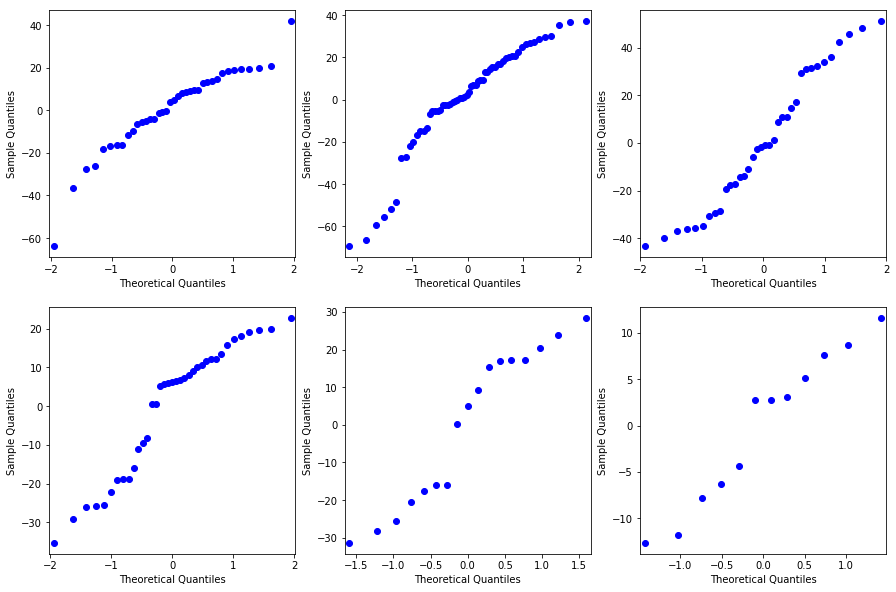

In [26]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i in range(0,len(agegroup)):
    if i < 3:
        sm.qqplot(df_orginal['residual'][df_orginal['AgeGroup']==agegroup[i]],ax=axs[0][i])
    else:
        sm.qqplot(df_orginal['residual'][df_orginal['AgeGroup']==agegroup[i]],ax=axs[1][i-3]) 

From the above we can see that the residuals are along the diagonal, which shows normal distribution of residuals.
The residuals are nearly normally distributed & centered on 0.

In [27]:
result_para

[Age              4.0296
 Annual_Income   -0.6769
 dtype: float64, Age              1.6762
 Annual_Income    0.1718
 dtype: float64, Age              0.5828
 Annual_Income    0.2917
 dtype: float64, Age    0.7401
 dtype: float64, Age    0.5358
 dtype: float64, Annual_Income    0.6344
 Age              0.2173
 dtype: float64]

In [28]:

for i in range(0,len(result_para)):
    
    tempString = str(agegroup[i]) + ':  Spending Score = ' 
        
    if(result_para[i].get("Age") != None):
        tempString += str(result_para[i].Age) + " * Age " 
        
    if(result_para[i].get("Annual_Income") != None):
        if (result_para[i].Annual_Income < 0):
            tempString += " - "
        else:
            tempString += " + "
        tempString += str(abs(result_para[i].Annual_Income)) + " * Annual Income"
    
    print(tempString)
    

Below 25:  Spending Score = 4.0296 * Age  - 0.6769 * Annual Income
26 - 35:  Spending Score = 1.6762 * Age  + 0.1718 * Annual Income
36 - 45:  Spending Score = 0.5828 * Age  + 0.2917 * Annual Income
46 - 55:  Spending Score = 0.7401 * Age 
56 - 65:  Spending Score = 0.5358 * Age 
Above 66:  Spending Score = 0.2173 * Age  + 0.6344 * Annual Income


### Coefficients (Slope) of Age and Annual Income explained:
1. For Age Group Below 25:
    a. 1 unit increase in Age results in 4.0296 unit increase in Spending Score.
    b. 1 unit increase in Annual Income results in 0.6769 unit decrease in Spending Score.
2. For Age Group 26 - 35:
    a. 1 unit increase in Age results in 1.6762 unit increase in Spending Score.
    b. 1 unit increase in Annual Income results in 0.1718 unit increase in Spending Score.
3. For Age Group 36 - 45:
    a. 1 unit increase in Age results in 0.5828 unit increase in Spending Score.
    b. 1 unit increase in Annual Income results in 0.2917 unit increase in Spending Score.
4. For Age Group 46 - 55:
    a. 1 unit increase in Age results in 0.7401 unit increase in Spending Score.
    b. Based on Forward Selection results Annual Income is not used in the model for Age Group 46 - 55.
5. For Age Group 56 - 65:
    a. 1 unit increase in Age results in 0.5358 unit increase in Spending Score.
    b. Based on Forward Selection results Annual Income is not used in the model for this age group.
6. For Age Group Above 65:
    a. 1 unit increase in Age results in 0.2173 unit increase in Spending Score.
    b. 1 unit increase in Annual Income results in 0.6344 unit increase in Spending Score.

In [29]:
result_Tval

[Age              0.0
 Annual_Income    0.0
 dtype: float64, Age              0.00
 Annual_Income    0.11
 dtype: float64, Age              0.13
 Annual_Income    0.15
 dtype: float64, Age    0.0
 dtype: float64, Age    0.0
 dtype: float64, Annual_Income    0.01
 Age              0.19
 dtype: float64]

In [30]:
for i in range(0,len(result_Tval)):
    
    tempString = str(agegroup[i]) + ':       ' 
        
    if(result_Tval[i].get("Age") != None):
        tempString += "Age T-Value: " + str(result_Tval[i].Age) + "  "
        
    if(result_Tval[i].get("Annual_Income") != None):
        tempString += "Annual_Income T-Value: " + str(abs(result_Tval[i].Annual_Income)) 
    
    print(tempString)

Below 25:       Age T-Value: 0.0  Annual_Income T-Value: 0.0
26 - 35:       Age T-Value: 0.0  Annual_Income T-Value: 0.11
36 - 45:       Age T-Value: 0.13  Annual_Income T-Value: 0.15
46 - 55:       Age T-Value: 0.0  
56 - 65:       Age T-Value: 0.0  
Above 66:       Age T-Value: 0.19  Annual_Income T-Value: 0.01


### P-Value Explained:
1.	For Age Group Below 25: 
    P-Value for Age is 0.0 (<0.05 – Age is a statistically significantly parameter in this case)
    P-Value for Annual Income is 0.0 (<0.05 – Annual Income is a statistically significantly parameter in this case)
2.	For Age Group 26 - 35: 
    P-Value for Age is 0.00 (<0.05 – Age is a statistically significantly parameter in this case)
    P-Value for Annual Income is 0.11 (>0.05 – Annual Income is not a statistically significantly parameter in this case)
3.	For Age Group 36 - 45: 
    P-Value for Age is 0.13 (<0.05 – Age is not a statistically significantly parameter in this case)
    P-Value for Annual Income is 0.15 (>0.05 – Annual Income is not a statistically significantly parameter in this case)
4.	For Age Group 46 - 55: 
    P-Value for Age is 0.00 (<0.05 – Age is a statistically significantly parameter in this case)
    Annual Income is not considered in the model.
5.	For Age Group 56 - 65: 
    P-Value for Age is 0.00 (<0.05 – Age is a statistically significantly parameter in this case)
    P-Value for Annual Income is 0.01 (<0.05 – Annual Income is a statistically significantly parameter in this case)
6.	For Age Group Above 65: 
    P-Value for Age is 0.01 (<0.05 – Age is a statistically significantly parameter in this case)
    P-Value for Annual Income is 0.19 (>0.05 – Annual Income is not a statistically significantly parameter in this case)


In [31]:
result_RS

[0.89, 0.86, 0.7, 0.83, 0.71, 0.97]

In [32]:
result_RS

for i in range(0,len(result_RS)):
    
    tempString = str(agegroup[i]) + ':       ' 
        
    if(result_Tval[i].get("Age") != None):
        tempString += "R2 = " + str(result_RS[i]) + "  "
        
    print(tempString)


Below 25:       R2 = 0.89  
26 - 35:       R2 = 0.86  
36 - 45:       R2 = 0.7  
46 - 55:       R2 = 0.83  
56 - 65:       R2 = 0.71  
Above 66:       R2 = 0.97  


### R-Squared Explained:
1. For Age Group Below 25: R-squared value is 0.89.
    89% variance in spending score can be explained by the regression model using Age and Annual Income as the dependent variables.
2. For Age Group 26 - 35: R-squared value is 0.86.
    86% variance in spending score can be explained by the regression model using Age and Annual Income as the dependent variables.
3. For Age Group 36 - 45: R-squared value is 0.7.
    70% variance in spending score can be explained by the regression model using Age and Annual Income as the dependent variables.
4. For Age Group 46 - 55: R-squared value is 0.83.
    83% variance in spending score can be explained by the regression model using Age as the dependent variables.
5. For Age Group 56 - 65: R-squared value is 0.71.
    71% variance in spending score can be explained by the regression model using Age as the dependent variables.
6. For Age Group Above 65: R-squared value is 0.97.
    97% variance in spending score can be explained by the regression model using Age and Annual Income as the dependent variables.

### Observations:
1. R-squared for regression on each age group improve significantly. 
2. The residuals are normally distributed. 
3. Some independent variables have T-value higher than 5%, suggesting that they are not a significant determinant for the spending_score. However, we argue that including those variables gives us the best predicting power as combining them with other variables yield highest R-squared.  
4. Annual_Income is negatively correlated with the spending_score for customers below 25. 
5. Annual_Income does not seem to have any relationship with the spending_score for customers between 46 years old to 65 year old. 
6. There are not many data points for the age group above 56 (56-65 and above 66). Therefore, the regression results in these two groups could change significantly with more data collection.  


# Bayesian Linear Regression with PyMC3
Now, we are going to introduce regression modelling in the Bayesian framework and carry out inference using the PyMC3 MCMC library. 
In a Bayesian framework, linear regression is stated in a probabilistic manner. That is, we reformulate the above linear regression model to use probability distributions. In the Bayesian formulation we receive an entire probability distribution that characterises our uncertainty on the different β coefficients. The immediate benefit of this is that after taking into account any data we can quantify our uncertainty in the β parameters via the variance of this posterior distribution. A larger variance indicates more uncertainty.

### Plotting the heatmap to find out correlation between different parameters.

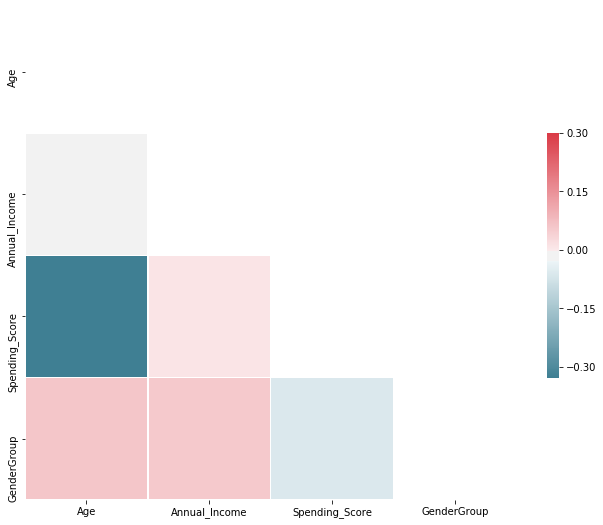

In [33]:
import seaborn

# Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

Looking at the heatmap we can see Age, Annual Income and GenderGroup show statistical relavance to Spending score as these show up with darker shades as shown by the scale. We see a strong correlation between Age and Spending Score, and some correlation between Annual Income and Spending Score.

## Create Model in PyMC3 and Sample from Posterior
We now build the model using the formula 'Spending_Score ~ Age + Annual_Income' as evident from heat map, and a normal distribution for the data likelihood. Then, we let a Markov Chain Monte Carlo algorithm draw samples from the posterior to approximate the posterior for each of the model parameters

The sampling algorithm chosen by PYMC3 module is NUTS sampler i.e. No U-turn Sampler.

We draw 20000 sample sets with 2 chains and run the GLM model for the formula: Spending_Score ~ Age + Annual_Income -1
As seen from the formula, we use Age and Annual Income and remove the intercept from consideration.
We do this for the same 6 age groups as identified before (below 25, 26 – 35, 36 – 45, 46 – 55, 56 – 65, Above 65).


In [34]:
linear_trace = []
for i in range(0,len(agegroup)):
    with pm.Model() as linear_model:
        data = df.loc[:,{'Age','Annual_Income','Spending_Score'}][df.loc[:,'AgeGroup']==agegroup[i]]
        family = pm.glm.families.Normal()
        pm.GLM.from_formula('Spending_Score ~ Age + Annual_Income -1', data, family = family)

        linear_trace.append(pm.sample(draws=20000, chains = 2, progressbar=True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Annual_Income, Age]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:50<00:00, 806.24draws/s]
The acceptance probability does not match the target. It is 0.8819242696713406, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Annual_Income, Age]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:51<00:00, 790.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, Annual_Income, Age]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:58<00:00, 700.62draws/s]
The acceptance probability does not match the target. It is 0.884478644872629, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning N

## Examining Bayesian Linear Regression Results

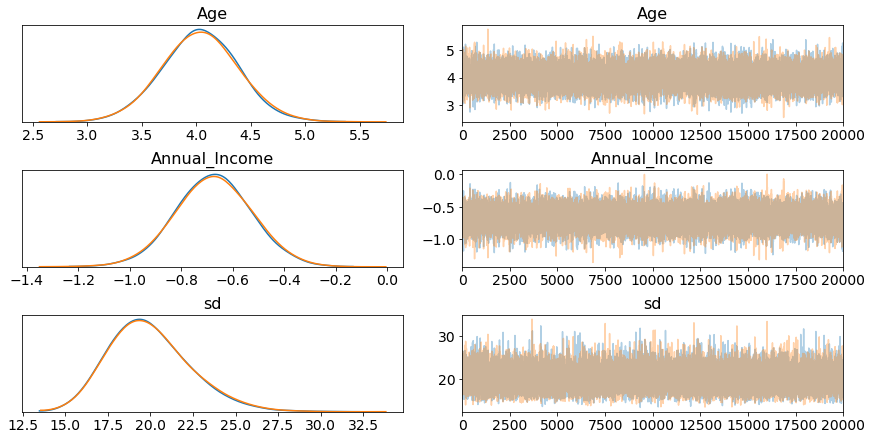

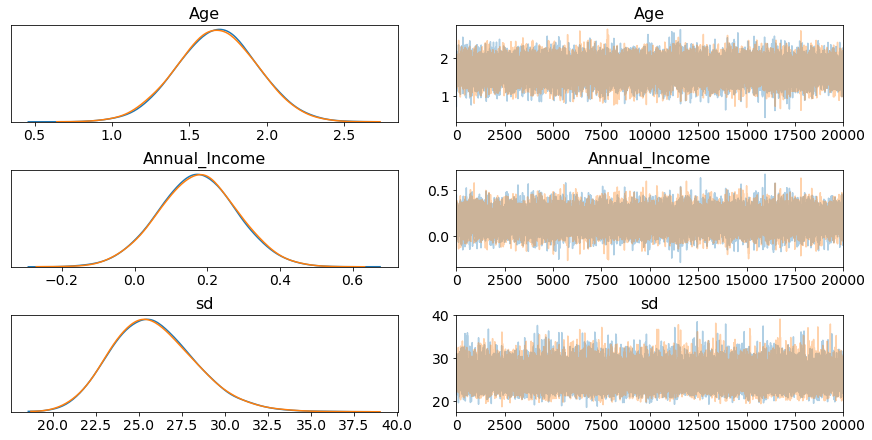

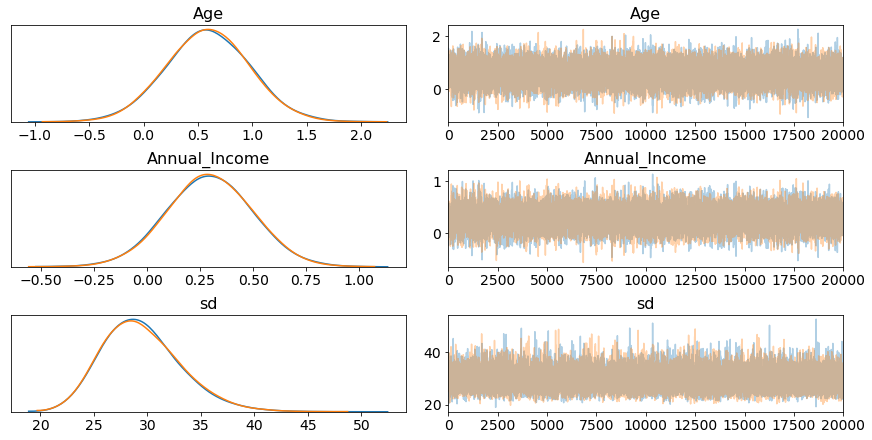

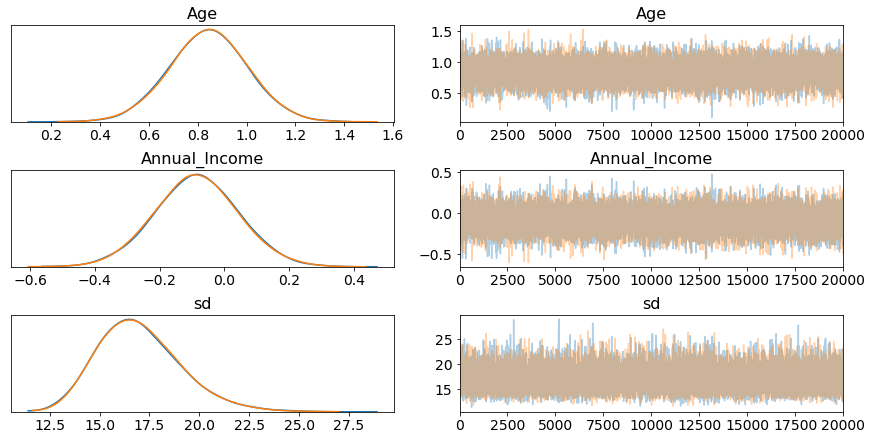

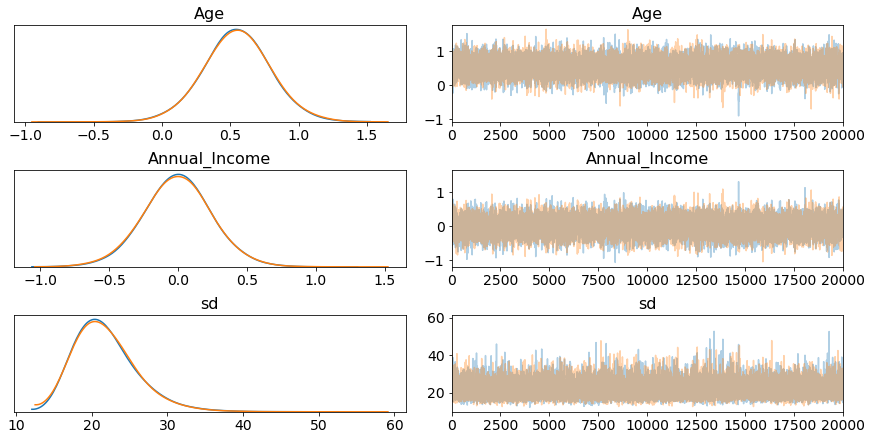

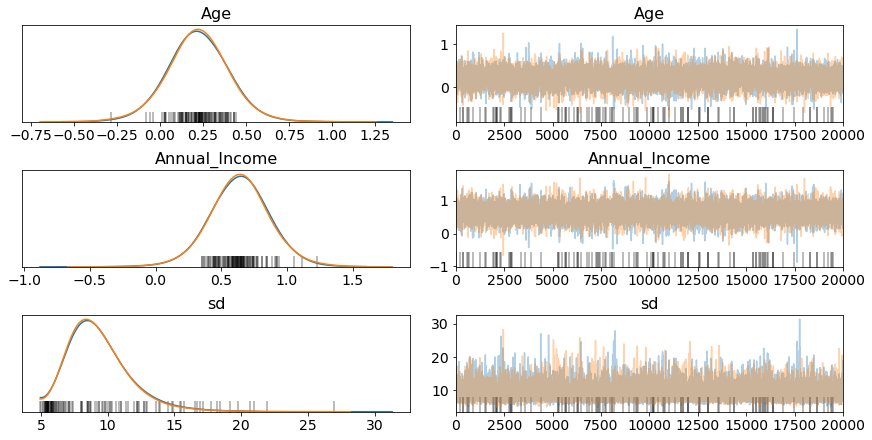

In [35]:
for i in range(0,len(linear_trace)):
    pm.traceplot(linear_trace[i])

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with 
the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate 
that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of 
values for each weight. The right side shows the different sample values drawn as the sampling process runs.

## Plotting posterior distributions

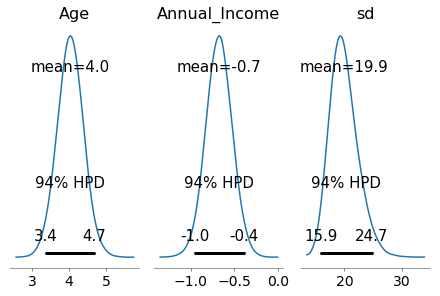

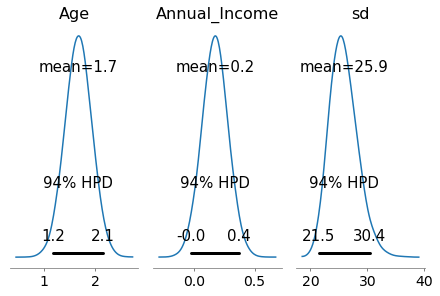

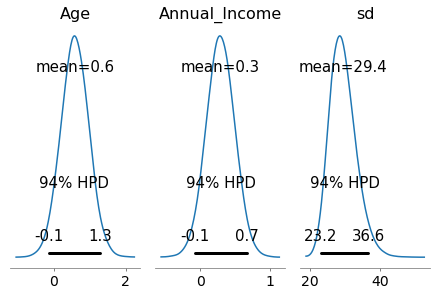

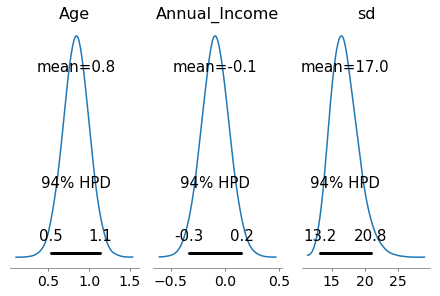

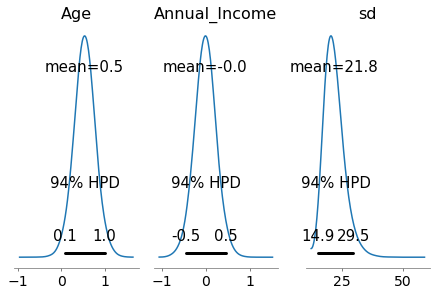

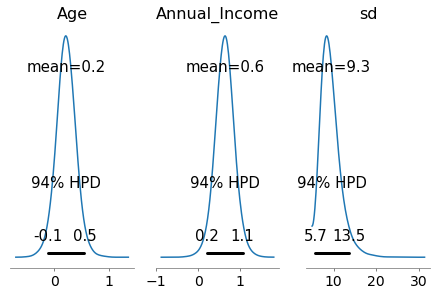

In [36]:
for i in range(0, len(linear_trace)):
    pm.plot_posterior(linear_trace[i], text_size=18, figsize=(6,4))

Bayesian inference does not give us only one best fitting line (as maximum likelihood does) but rather a whole posterior distribution of likely parameters.
Linear Trace Interpretation: The left side of the traceplot shows the marginal posterior: 

•	X-Axis: The values for the variable

•	Y-Axis: The probability for the variable (as determined by sampling)

•	The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. 

•	From the left side we can see that there is a range of values for each weight. 

•	The right side shows the different sample values drawn as the sampling process runs.

There are a couple of things to see here: 

•	Our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

•	The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (x is the regression coefficient and sigma is the standard deviation of our normal).


In [37]:
# Print out the mean variable weight from the trace
for i in range(0, len(linear_trace)):
    for variable in linear_trace[i].varnames:
        print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(linear_trace[i][variable])))

Variable: Age             Mean weight in model: 4.0302
Variable: Annual_Income   Mean weight in model: -0.6772
Variable: sd_log__        Mean weight in model: 2.9852
Variable: sd              Mean weight in model: 19.9297
Variable: Age             Mean weight in model: 1.6750
Variable: Annual_Income   Mean weight in model: 0.1721
Variable: sd_log__        Mean weight in model: 3.2485
Variable: sd              Mean weight in model: 25.8627
Variable: Age             Mean weight in model: 0.5841
Variable: Annual_Income   Mean weight in model: 0.2914
Variable: sd_log__        Mean weight in model: 3.3745
Variable: sd              Mean weight in model: 29.4314
Variable: Age             Mean weight in model: 0.8414
Variable: Annual_Income   Mean weight in model: -0.0876
Variable: sd_log__        Mean weight in model: 2.8255
Variable: sd              Mean weight in model: 16.9906
Variable: Age             Mean weight in model: 0.5429
Variable: Annual_Income   Mean weight in model: -0.0082
Var

## Interpretations of Weights
Based on the sign and location of the weights, we can make the following inferences regarding the features in our dataset:

- Based on Agegroup, Below 25, Age seems to have positive relation with spending score while Annual income has 
negative impact.
- In Agegroup between 26-45, both Age and Annual income has postive impact on spending score.
- When we go further down the age group with ages 56-65, we see a positive impact of age on spending score while 
annual income is negative.
- In Agegroup, above 66, both the factors has positive impact on age.



# Summary of MCMC model for different age groups

In [38]:
#Summary for ageGroup Below 25
pm.summary(linear_trace[0])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Age,4.030209,0.347802,0.002702,3.341562,4.713713,16871.147177,0.999976
Annual_Income,-0.677223,0.147374,0.001150,-0.962497,-0.382669,16849.688322,0.999981
sd,19.929667,2.389421,0.015117,15.520458,24.696135,21645.919592,1.000053


In [39]:
#Summary for ageGroup between 26 - 35
pm.summary(linear_trace[1])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Age,1.675029,0.256777,0.002115,1.185086,2.186545,14535.112128,1.000085
Annual_Income,0.172099,0.106918,0.000904,-0.037227,0.381304,14846.266952,1.000081
sd,25.862720,2.432368,0.016614,21.283444,30.682997,21230.215565,0.999994


In [40]:
#Summary for ageGroup Below 36 - 45
pm.summary(linear_trace[2])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Age,0.584134,0.380655,0.002751,-0.169284,1.325642,15313.560175,1.000001
Annual_Income,0.291406,0.200178,0.001488,-0.107936,0.675903,15342.480650,1.000005
sd,29.431426,3.655220,0.023202,22.882626,36.864700,18898.706913,0.999991


In [41]:
#Summary for ageGroup Below 46 - 55
pm.summary(linear_trace[3])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Age,0.841360,0.158451,0.001382,0.521311,1.143480,13799.980789,1.000051
Annual_Income,-0.087584,0.127977,0.001130,-0.338613,0.166250,13822.082463,1.000071
sd,16.990578,2.066886,0.013075,13.190328,21.103276,19819.201252,0.999991


In [42]:
#Summary for ageGroup Below 56 - 65
pm.summary(linear_trace[4])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Age,0.542929,0.239481,0.001756,0.065849,1.020983,14583.308432,1.000000
Annual_Income,-0.008167,0.242313,0.001752,-0.472676,0.492171,14611.650168,1.000003
sd,21.760903,4.097215,0.033258,14.694172,29.999044,17256.520054,1.000001


In [43]:
#Summary for ageGroup Below Above 66
pm.summary(linear_trace[5])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Age,0.216543,0.174097,0.001746,-0.133677,0.561504,10830.640359,1.000003
Annual_Income,0.634969,0.223273,0.002235,0.196350,1.087711,10816.130612,0.999994
sd,9.339491,2.307390,0.025853,5.674113,13.934031,8784.751114,1.000152


In [44]:
for i in range(0, len(linear_trace)):
    model_formula = 'Spending_Score = '
    for variable in linear_trace[i].varnames:
        model_formula += ' %0.2f * %s +' % (np.mean(linear_trace[i][variable]), variable)
    ' '.join(model_formula.split(' ')[:-1])
    print(model_formula)

Spending_Score =  4.03 * Age + -0.68 * Annual_Income + 2.99 * sd_log__ + 19.93 * sd +
Spending_Score =  1.68 * Age + 0.17 * Annual_Income + 3.25 * sd_log__ + 25.86 * sd +
Spending_Score =  0.58 * Age + 0.29 * Annual_Income + 3.37 * sd_log__ + 29.43 * sd +
Spending_Score =  0.84 * Age + -0.09 * Annual_Income + 2.83 * sd_log__ + 16.99 * sd +
Spending_Score =  0.54 * Age + -0.01 * Annual_Income + 3.06 * sd_log__ + 21.76 * sd +
Spending_Score =  0.22 * Age + 0.63 * Annual_Income + 2.21 * sd_log__ + 9.34 * sd +


# Evaluating MCMC model

In [51]:
def evaluate_trace(trace, X_train, X_test, y_train, y_test):
    
    #print(trace)
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    var_weights = pd.DataFrame(var_dict)
    var_means = var_weights.mean(axis=0)
    
    X_test_temp = X_test[['Age', 'Annual_Income']]
    var_means_temp = var_means[['Age', 'Annual_Income']]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test_temp.index, columns = ['estimate'])

    for row in X_test_temp.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means_temp), np.array(row[1]))
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))

In [52]:
for i in range(0, len(linear_trace)):
    evaluate_trace(linear_trace[i], X_train, X_test, y_train, y_test)

Model  MAE: 74.3959
Model RMSE: 97.4595
Model  MAE: 39.5165
Model RMSE: 48.9333
Model  MAE: 25.6242
Model RMSE: 30.9664
Model  MAE: 30.3503
Model RMSE: 37.0111
Model  MAE: 32.1161
Model RMSE: 39.1298
Model  MAE: 24.3865
Model RMSE: 31.3029


# Prediction of response
Below we create the posterior plots which provide insight into the samples posterior predictive regression lines.

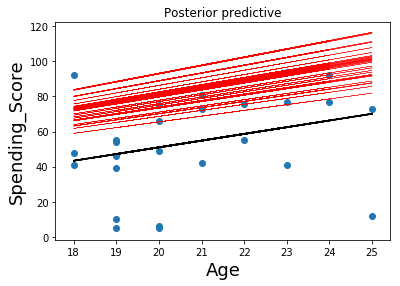

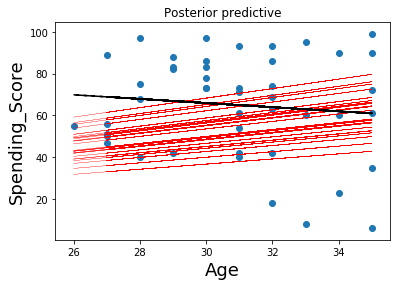

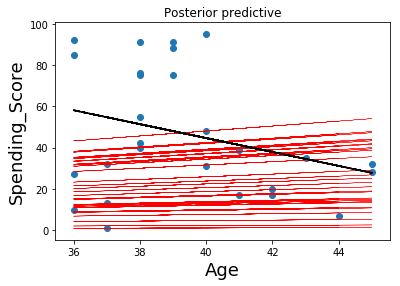

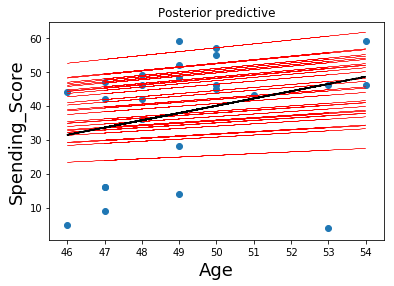

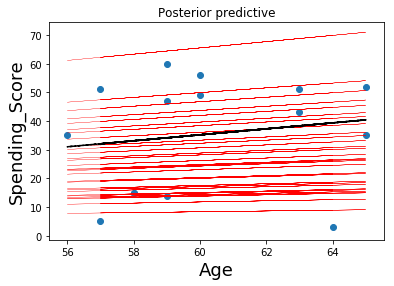

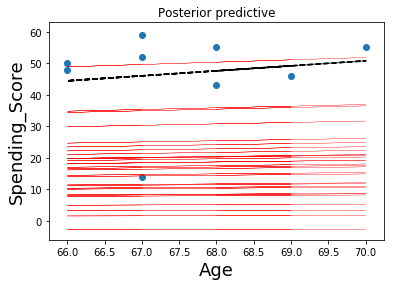

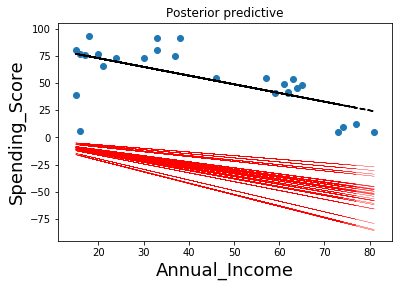

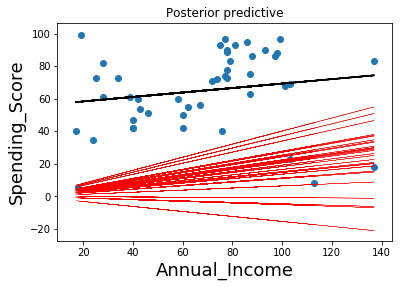

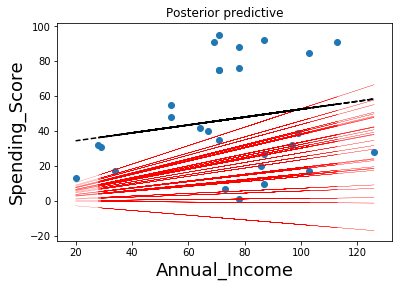

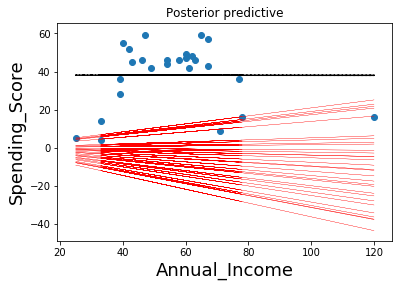

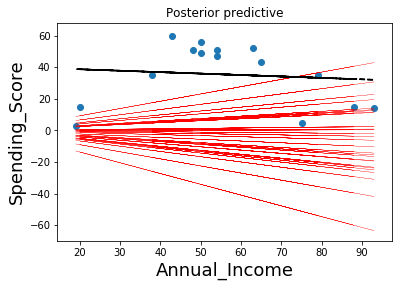

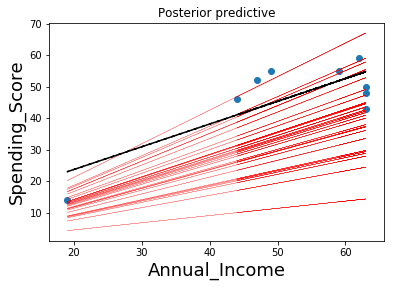

In [92]:
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()

for i in range(0, len(linear_trace)):
    data = X_train.loc[:,{'Age','Annual_Income','Spending_Score'}][X_train.loc[:,'AgeGroup']==agegroup[i]]
    lin_reg.fit(data.Age.values.reshape(-1, 1), data.Spending_Score)
    pm.plot_posterior_predictive_glm(linear_trace[i], eval=data['Age'], 
                                 color='red', label = 'Bayesian Posterior Fits',
                                 lm= lambda x, sample:
                                 sample['Age']*x)

    plt.plot(data.Age.values.reshape(-1, 1), lin_reg.predict(data.Age.values.reshape(-1, 1)), 'k--', label='Linear Regression')
    plt.scatter(x=data["Age"], y=data["Spending_Score"])
    plt.ylabel('Spending_Score', size = 18)
    plt.xlabel('Age', size = 18)
    plt.show()
    
for i in range(0, len(linear_trace)):
    data = X_train.loc[:,{'Age','Annual_Income','Spending_Score'}][X_train.loc[:,'AgeGroup']==agegroup[i]]
    lin_reg.fit(data.Annual_Income.values.reshape(-1, 1), data.Spending_Score)
    pm.plot_posterior_predictive_glm(linear_trace[i], eval=data['Annual_Income'], 
                                 color='red', label = 'Bayesian Posterior Fits',
                                 lm= lambda x, sample:
                                 sample['Annual_Income']*x)

    plt.plot(data.Annual_Income.values.reshape(-1, 1), lin_reg.predict(data.Annual_Income.values.reshape(-1, 1)), 'k--', label='Linear Regression')
    plt.scatter(x=data["Annual_Income"], y=data["Spending_Score"])
    plt.ylabel('Spending_Score', size = 18)
    plt.xlabel('Annual_Income', size = 18)
    plt.show()
    

We create the posterior plots which provide insight into the sample’s posterior predictive regression lines.

In the GLM we do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them.

Estimated regression lines are very similar to the true regression line. But since we only have limited data, we have uncertainty in our estimates, here expressed by the variability of the lines.

# Prediction for single point

Below is the point prediction (for Age = 24, using Bayesian Regression. We see that Bayesian prediction mean value almost coincides with the linear regression output. The data should be rich enough to predict correctly.

/Users/jyoti/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


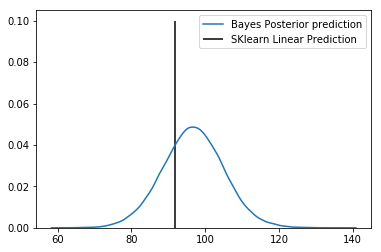

In [91]:
data = X_train.loc[:,{'Age','Annual_Income', 'Spending_Score'}][X_train.loc[:,'AgeGroup']==agegroup[0]]
lin_reg.fit(data.Age.values.reshape(-1, 1), data.Spending_Score)

single_point_prediction = linear_trace[0]['Age']*24

plt.vlines(x=lin_reg.coef_[0]*24, ymin=0, ymax=0.1,
      label='SKlearn Linear Prediction', )
sns.kdeplot(single_point_prediction, label='Bayes Posterior prediction')
plt.show()

### Comparison of the two models:

As we can see from above, coefficients from both regression models are very close. Below is a summary of comparison:

•	Below 25 Age Group: Coefficient for Age from OLS is 4.0296, which is very close to Age coefficient of 4.03 from Bayesian Regression.

Coefficient for Annual Income from OLS is (-0.6769), which is very close to the -0.6769 value from Bayesian Regression.
Overall, shows a very similar dependency on Age and Annual Income in this group.

•	26 – 35 Age Group: Coefficient for Age from OLS is 1.6762, which is very close to Age coefficient of 1.68 from Bayesian Regression.
Coefficient for Annual Income from OLS is 0.1718, which is very close to the 0.17 value from Bayesian Regression.
Overall, shows a very similar dependency on Age and Annual Income in this group.

•	36 – 45 Age Group: Coefficient for Age from OLS is 0.5828, which is very close to Age coefficient of 0.58 from Bayesian Regression.
Coefficient for Annual Income from OLS is 0.2917, which is very close to the 0.29 value from Bayesian Regression.
Overall, shows a very similar dependency on Age and Annual Income in this group.

•	46 – 55 Age Group: Coefficient for Age from OLS is 0.7401, which is only different from Age coefficient of 0.84 from Bayesian Regression by 0.09 units.
OLS regression for this age group does not use Annual Income as one of the independent variables, determined by forward selection. However, in Bayesian Regression we have used both age and annual income. Coefficient for Annual Income is -0.09 from Bayesian Regression, indicating a very minimal and a negative dependency of spending score on annual income.
Overall both models show very similar results.

•	56 – 65 Age Group: Coefficient for Age from OLS is 0.5358, which is very close to Age coefficient of 0.54 from Bayesian Regression.
OLS regression for this age group does not use Annual Income as one of the independent variables, determined by forward selection. However, in Bayesian Regression we have used both age and annual income. Coefficient for Annual Income is -0.01 from Bayesian Regression, indicating a very minimal and a negative dependency of spending score on annual income.
Overall, both models show very similar results.

•	Above 65 Age Group: Coefficient for Age from OLS is 0.2173, which is very close to Age coefficient of 0.22 from Bayesian Regression.
Coefficient for Annual Income from OLS is 0.6344, which is very close to the 0.63 value from Bayesian Regression.
Overall, shows a very similar dependency on Age and Annual Income in this group.